In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

print("Path to dataset files:", path)

100%|██████████| 0.98M/0.98M [00:00<00:00, 2.48MB/s]

Extracting files...
Path to dataset files: /Users/sam/.cache/kagglehub/datasets/uciml/default-of-credit-card-clients-dataset/versions/1


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer

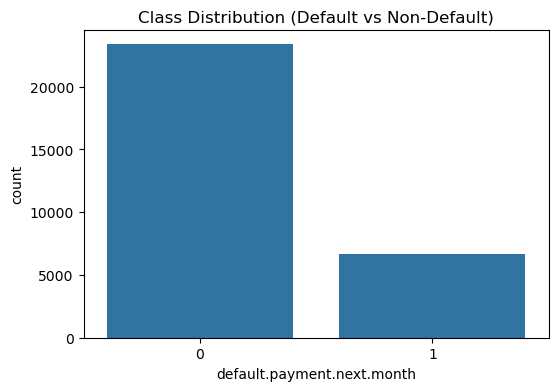

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("UCI_Credit_Card.csv")
plt.figure(figsize=(6, 4))
sns.countplot(x='default.payment.next.month', data=df)
plt.title('Class Distribution (Default vs Non-Default)')
plt.show()

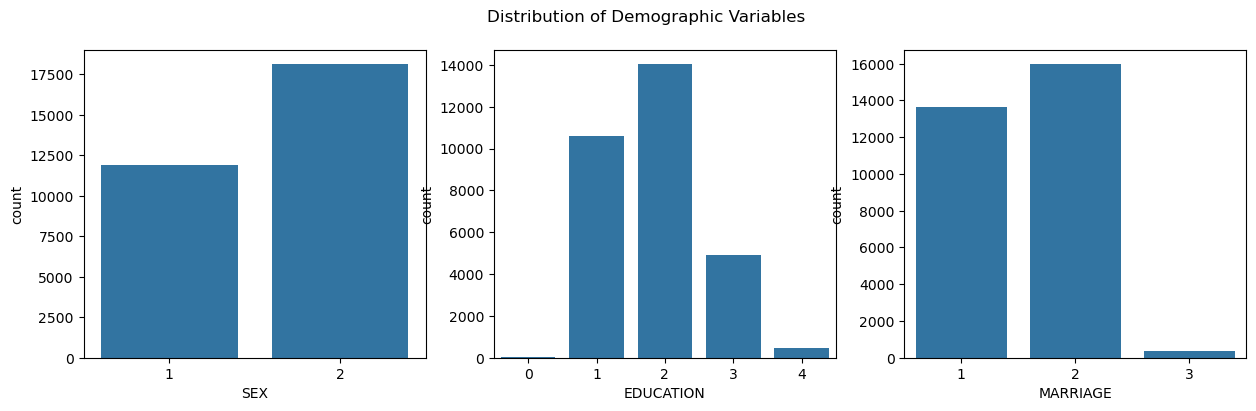

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.countplot(x='SEX', data=df, ax=axes[0])
sns.countplot(x='EDUCATION', data=df, ax=axes[1])
sns.countplot(x='MARRIAGE', data=df, ax=axes[2])
plt.suptitle('Distribution of Demographic Variables')
plt.show()

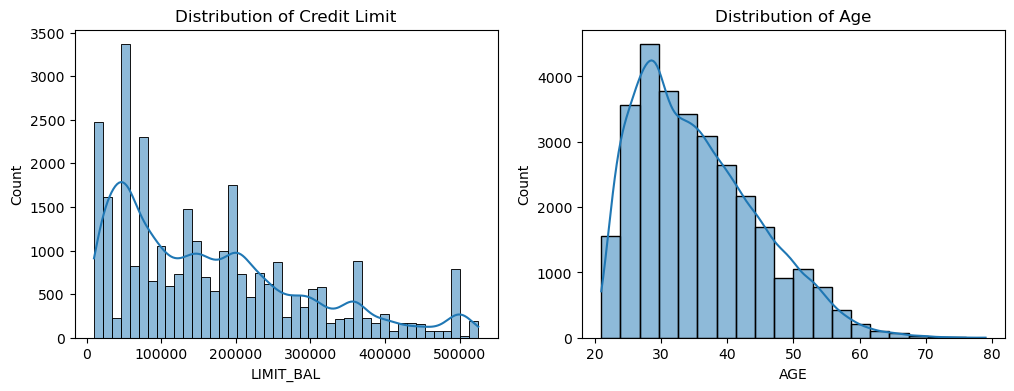

In [59]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['LIMIT_BAL'], kde=True)
plt.title('Distribution of Credit Limit')
plt.subplot(1, 2, 2)
sns.histplot(df['AGE'], kde=True, bins=20)
plt.title('Distribution of Age')
plt.show()

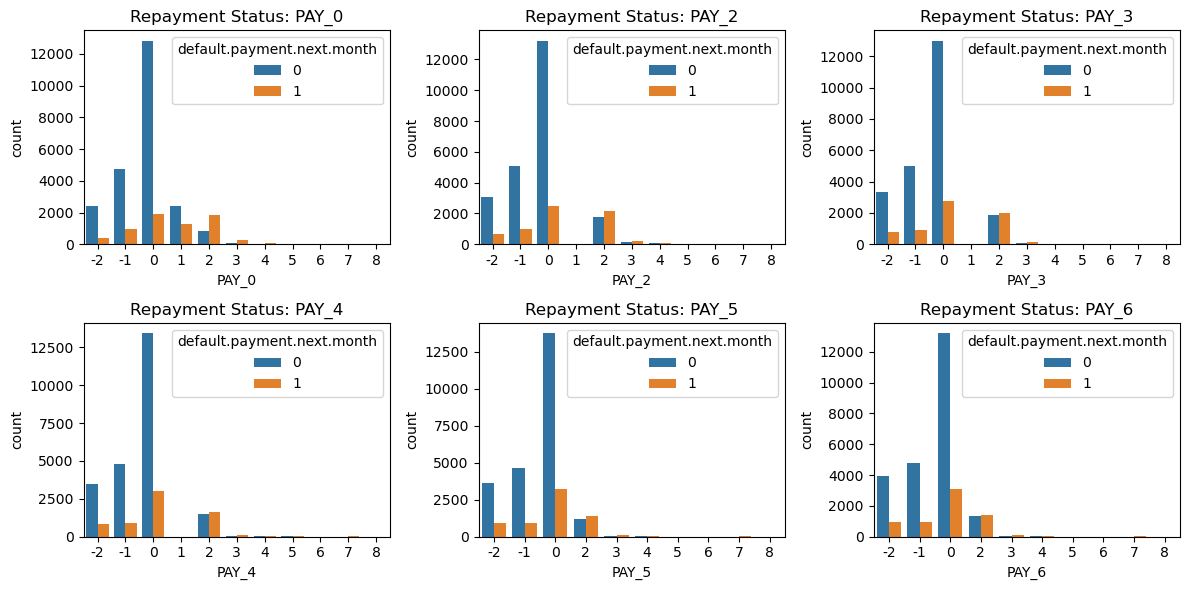

In [60]:
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
plt.figure(figsize=(12, 6))
for i, col in enumerate(pay_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, data=df, hue='default.payment.next.month')
    plt.title(f'Repayment Status: {col}')
plt.tight_layout()
plt.show()

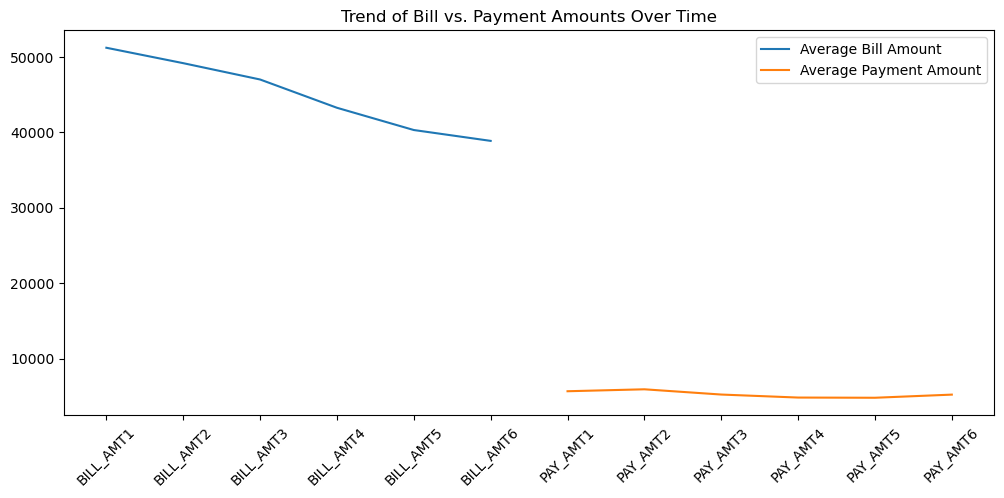

In [11]:
bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

plt.figure(figsize=(12, 5))
sns.lineplot(data=df[bill_columns].mean(), label='Average Bill Amount')
sns.lineplot(data=df[pay_amt_columns].mean(), label='Average Payment Amount')
plt.title('Trend of Bill vs. Payment Amounts Over Time')
plt.xticks(rotation=45)
plt.show()

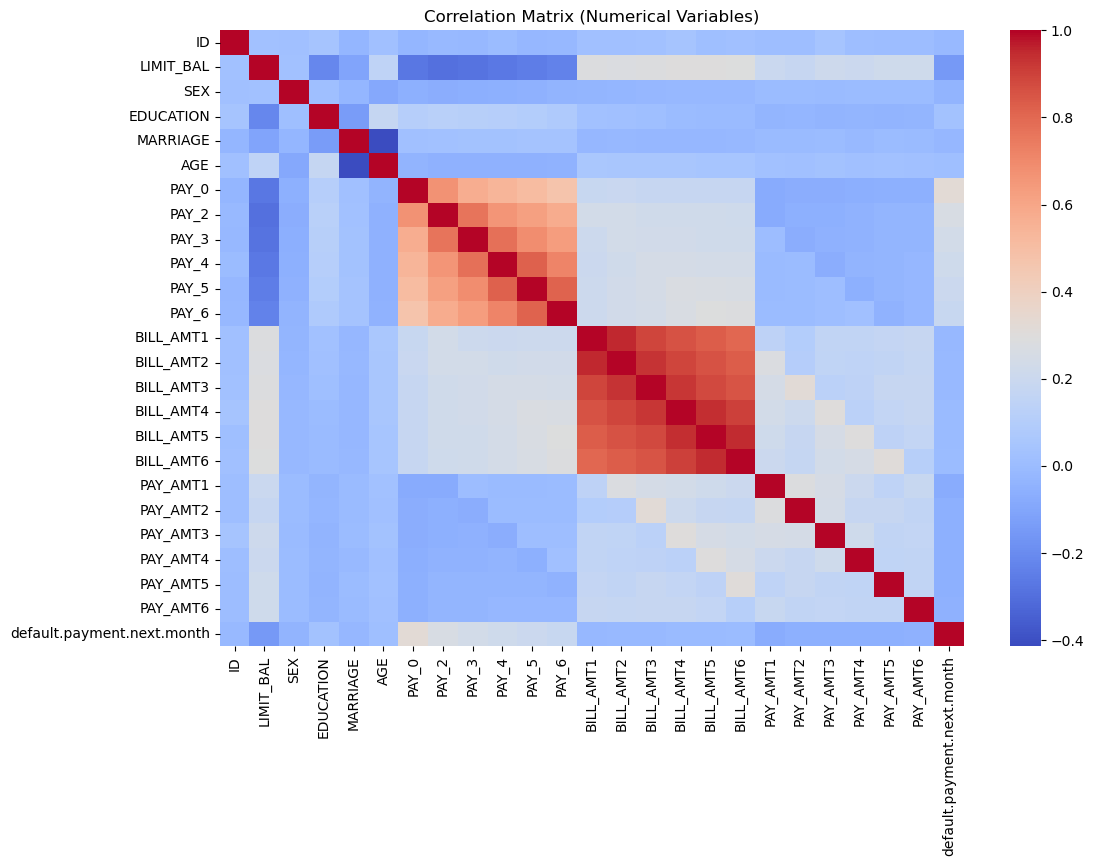

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Variables)')
plt.show()

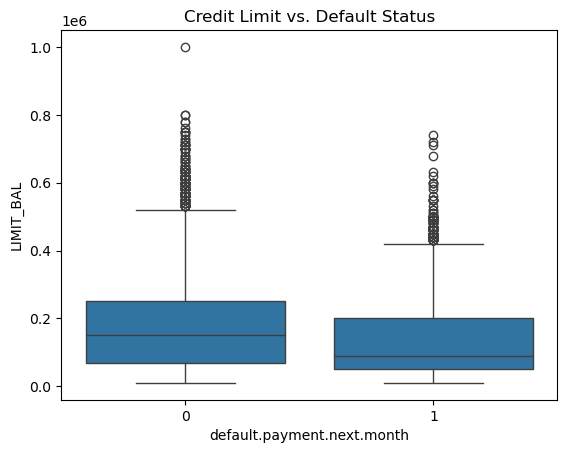

In [85]:
sns.boxplot(x='default.payment.next.month', y='LIMIT_BAL', data=df)
plt.title('Credit Limit vs. Default Status')
plt.show()

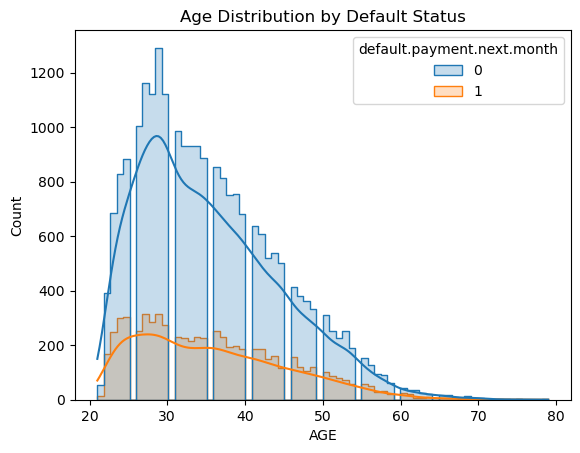

In [14]:
sns.histplot(data=df, x='AGE', hue='default.payment.next.month', element='step', kde=True)
plt.title('Age Distribution by Default Status')
plt.show()

In [120]:
# Group EDUCATION: Merge 5/6 into "unknown" (e.g., category 4)
df['EDUCATION'] = df['EDUCATION'].replace({5: 4, 6: 4, 0: 4})

# Similarly, check MARRIAGE for unexpected values (e.g., 0 or others)
df['MARRIAGE'] = df['MARRIAGE'].replace({0: 3})  # Assuming "others" is 3


In [121]:
# 1. Credit Utilization Ratio (Bill Amount / Credit Limit)
for i in range(1, 7):
    df[f'UTILIZATION_{i}'] = df[f'BILL_AMT{i}'] / df['LIMIT_BAL']

# 2. Payment Behavior: Total months of delay in the past 6 months
delay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df['TOTAL_DELAY_MONTHS'] = df[delay_columns].apply(lambda x: x[x > 0].sum(), axis=1)

# 3. Average payment amount (PAY_AMT1-6 normalized by credit limit)
pay_amt_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df['AVG_PAYMENT_RATIO'] = df[pay_amt_columns].mean(axis=1) / df['LIMIT_BAL']


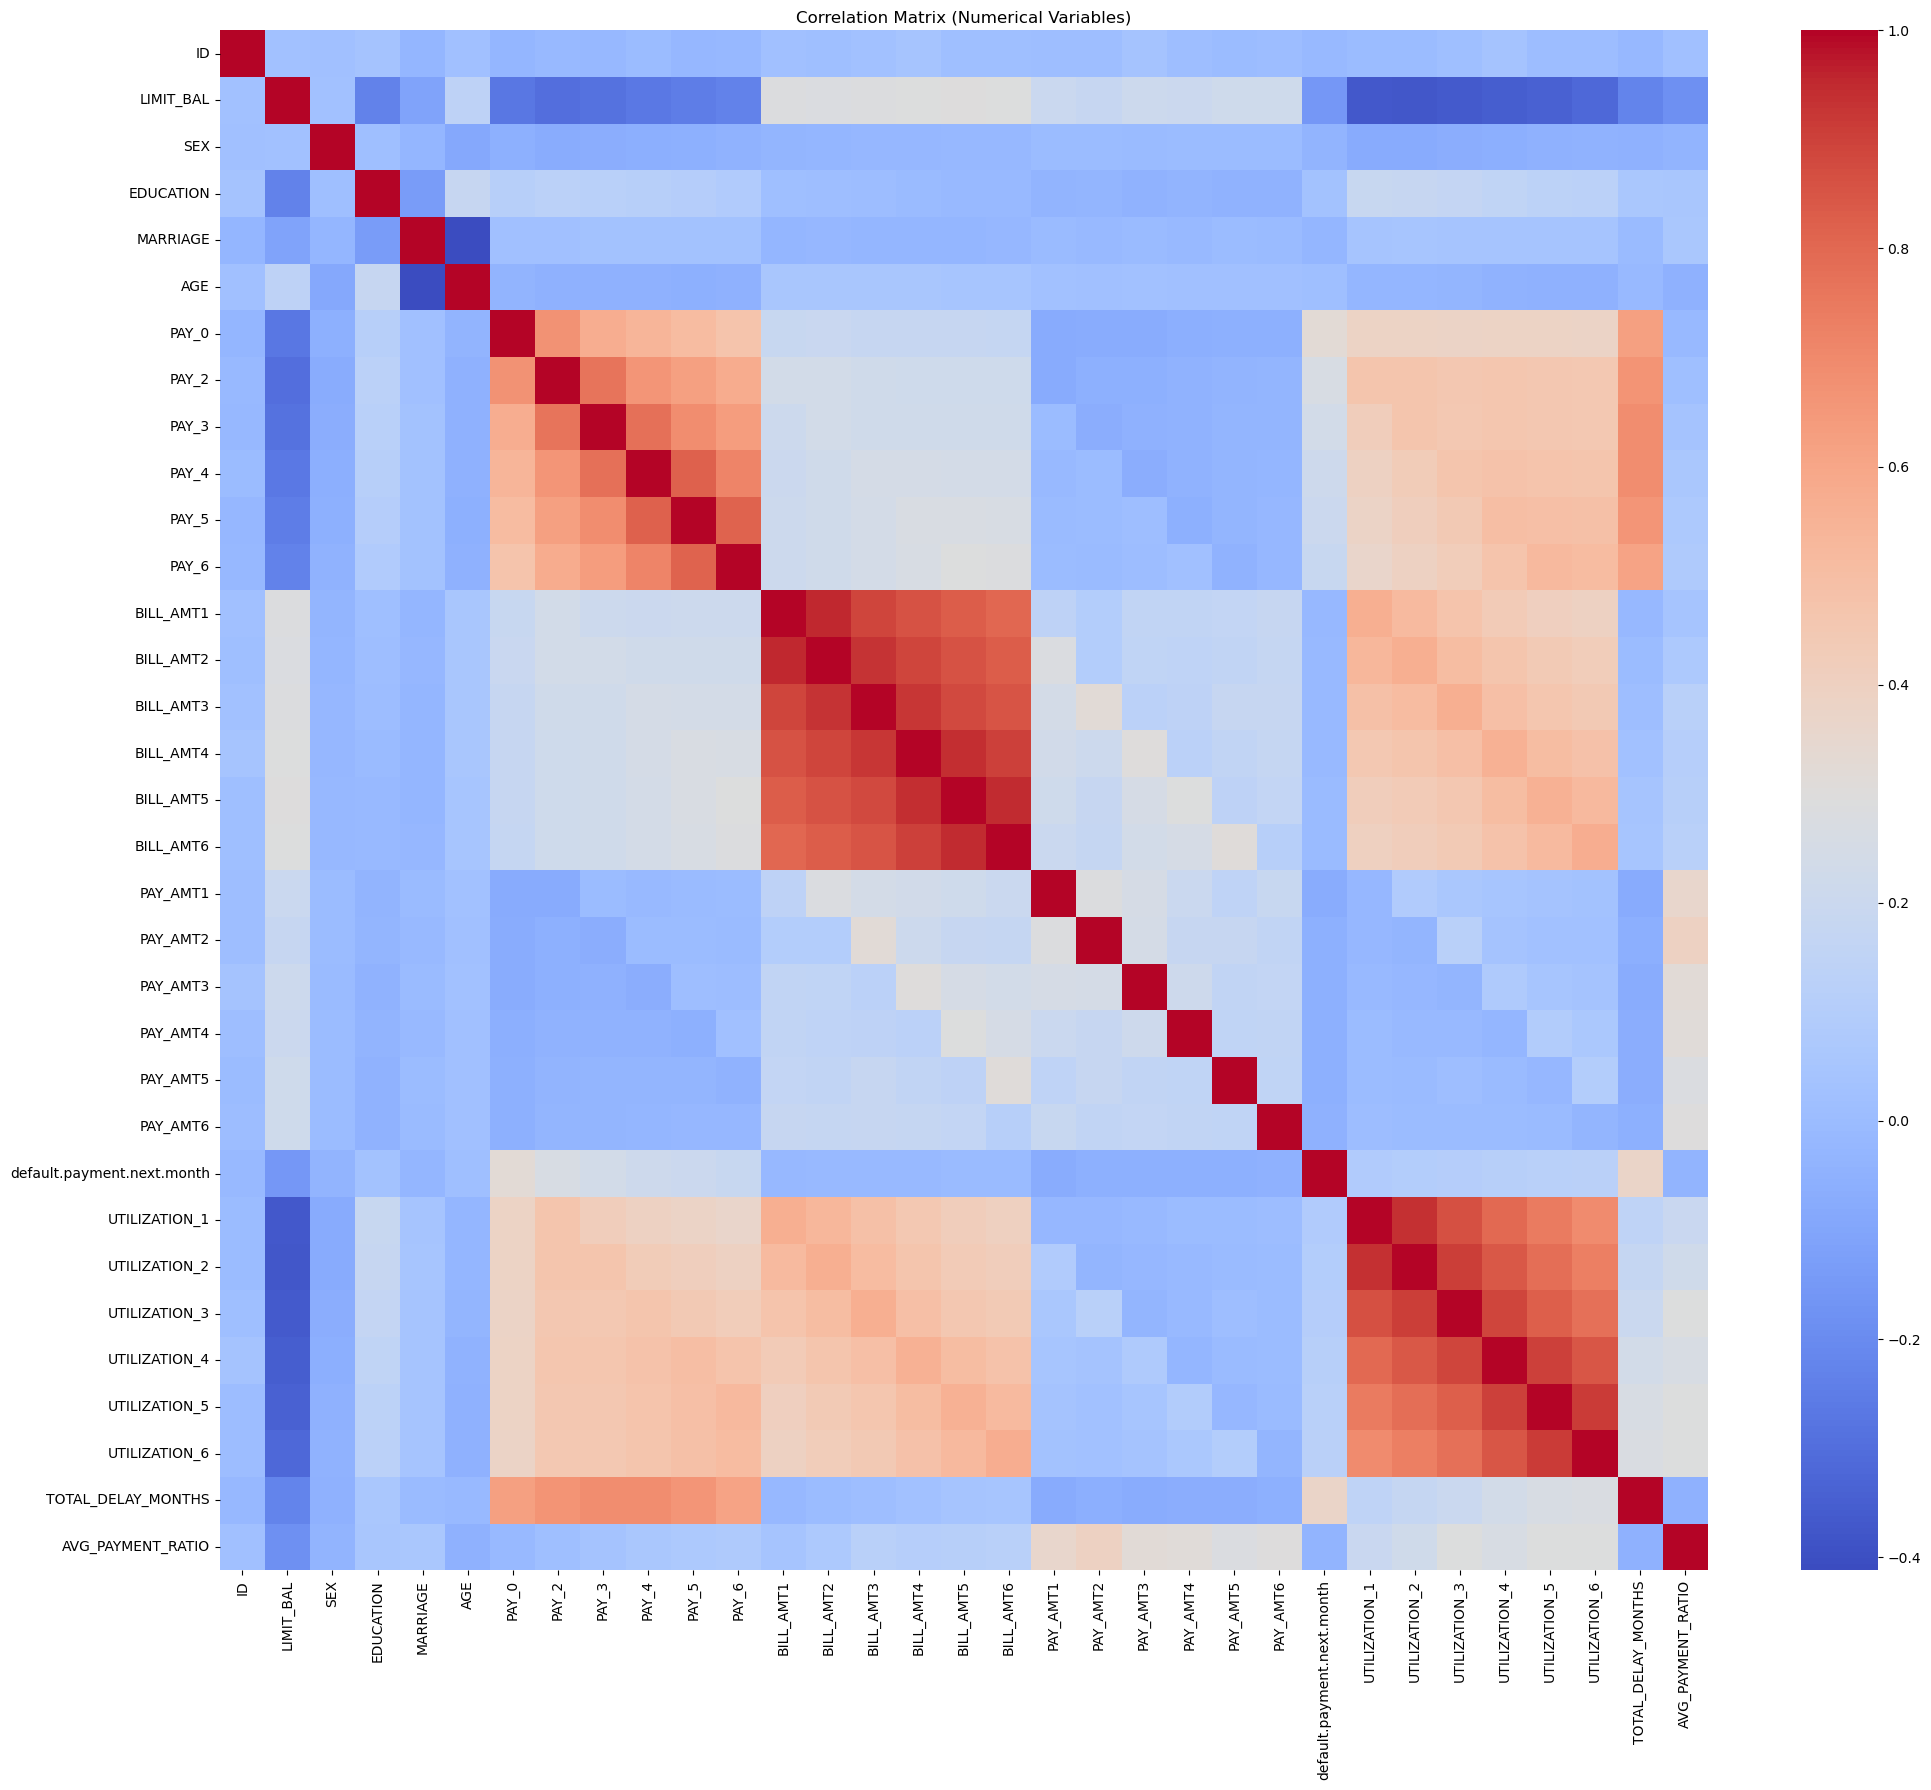

In [162]:
plt.figure(figsize=(24, 20))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Variables)')
plt.savefig("Correlation_matrix.pdf", format = "pdf")

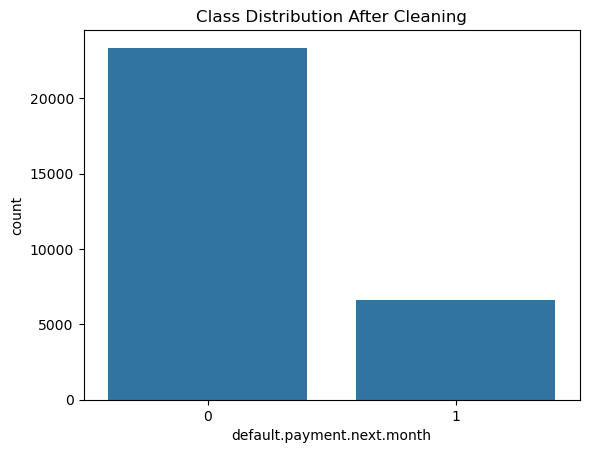

In [163]:
sns.countplot(x='default.payment.next.month', data=df)
plt.title('Class Distribution After Cleaning')
plt.show()


In [164]:
df.to_csv('cleaned_credit_data.csv', index=False)



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Load cleaned data
df = pd.read_csv('cleaned_credit_data.csv')
X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']

# Train-test split (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [2]:
# Capping of training set as to not leak data into test set
Q1 = X_train['LIMIT_BAL'].quantile(0.25)
Q3 = X_train['LIMIT_BAL'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR

# Vectorized capping (efficient + readable)
X_train['LIMIT_BAL'] = X_train['LIMIT_BAL'].clip(upper=upper_limit)
X_test['LIMIT_BAL'] = X_test['LIMIT_BAL'].clip(upper=upper_limit)

In [3]:
categorical_cols = [
    'SEX', 'EDUCATION', 'MARRIAGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'  # Treat repayment status as categorical
]
numerical_cols = [
    'LIMIT_BAL', 'AGE', 
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'UTILIZATION_1', 'UTILIZATION_2', 'UTILIZATION_3', 
    'UTILIZATION_4', 'UTILIZATION_5', 'UTILIZATION_6',
    'TOTAL_DELAY_MONTHS', 'AVG_PAYMENT_RATIO'
]
X_train[categorical_cols] = X_train[categorical_cols].astype('category')
X_test[categorical_cols] = X_test[categorical_cols].astype('category')


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
# Define columns for each encoding type
nominal_cols = ['SEX', 'MARRIAGE']                   # Use one-hot
ordinal_cols = ['EDUCATION', 'PAY_0', 'PAY_2', 
                'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']  # Use ordinal
for col in ordinal_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    
# Define Ordinal Encoding order 
education_order = [['4', '1', '3', '2']]  # Example custom order for EDUCATION
pay_order = [['-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8']]

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        (
            'ordinal', 
            OrdinalEncoder(categories=education_order + pay_order*6), 
            ordinal_cols
        ),
        (
            'nominal', 
            OneHotEncoder(drop='first', handle_unknown='ignore'), 
            nominal_cols
        ),
        (
            'numerical', 
            StandardScaler(),  # Scale numerical features
            numerical_cols
        )
    ],
    remainder='drop'  # Leave numerical features unprocessed for now
)

# Fit on train, transform both sets
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

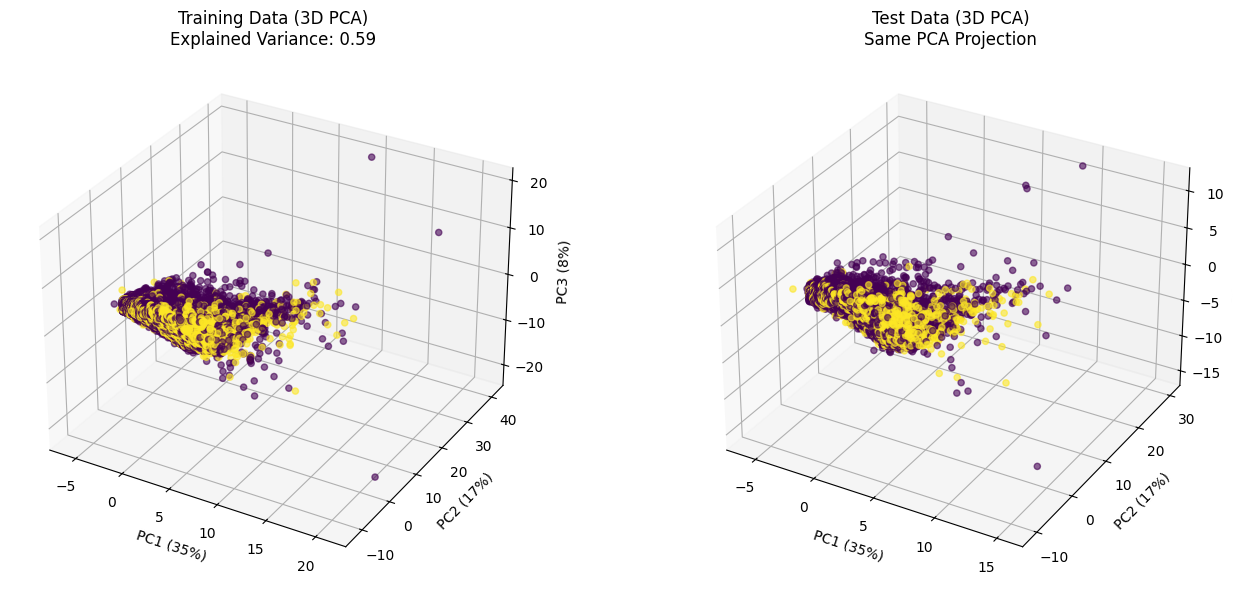

In [11]:
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import plotly.express as px 
# ==================================================
# 3D PCA Visualization (Matplotlib Version)
# ==================================================
# Fit PCA to 3 dimensions
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_encoded)
X_test_pca = pca.transform(X_test_encoded)

# Create 3D scatter plots
fig = plt.figure(figsize=(14, 6))

# Training Data (LEFT)
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2],
    c=y_train, alpha=0.6, cmap='viridis'  # Use any color scheme (Viridis avoids red/blue confusion)
)
ax1.set_title(f'Training Data (3D PCA)\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.0%})')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.0%})')
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.0%})')

# Test Data (RIGHT)
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(
    X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2],
    c=y_test, alpha=0.6, cmap='viridis'
)
ax2.set_title(f'Test Data (3D PCA)\nSame PCA Projection')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.0%})')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.0%})')
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.0%})')

# Adjust layout and save
plt.tight_layout()
plt.savefig('pca_3d.pdf', dpi=300, bbox_inches='tight')
plt.show()
fig = px.scatter_3d(
    pd.DataFrame(X_train_pca).assign(**{'Class': y_train}),
    x=0, y=1, z=2, 
    color='Class',
    color_discrete_map={0: 'blue', 1: 'red'},
    title=f'3D PCA Projection (Training Data)',
    labels={'0': 'PC1', '1': 'PC2', '2': 'PC3'}
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.show()
fig.write_html("pca_3d_interactive.html")  # Save as HTML to share


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_curve, 
    roc_auc_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline  # Critical for correct SMOTE usage

# =========================================
# Resampled Pipelines (Balanced Class)
# =========================================
logreg_bal_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),  # Applied only during training
    LogisticRegression(max_iter=1000, random_state=42)
)

rf_bal_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
)

xgb_bal_pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, eval_metric='logloss', random_state=42)
)

# ======================================
# Shared Preprocessor (From Earlier Code)
# ======================================
# Assume `preprocessor` is already defined as a ColumnTransformer 
# handling numeric/categorical features, e.g.:
# preprocessor = ColumnTransformer(transformers=[...])

# ======================
# Logistic Regression
# ======================
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000, 
        class_weight='balanced',  # Handles class imbalance
        random_state=42
    ))
])

# ======================
# Random Forest
# ======================
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',  # Balanced class weights
        max_depth=8,
        random_state=42
    ))
])

# ======================
# Gradient Boosted Forest
# ======================
gbf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(
        learning_rate=0.1,
        max_iter=400,
        max_depth=8,
        class_weight="balanced",
        random_state=42,
        categorical_features="from_dtype",
        early_stopping=True
    ))
])

# ======================
# XGBoost
# ======================
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # Handle imbalance
        max_depth=8,
        learning_rate=0.1,  
        subsample=0.8,
        eval_metric='logloss',
        random_state=42
    ))
])

# ======================================
# Train/Evaluate All Models (Example)
# ======================================
models = {
    # 'LogReg (Balanced)': logreg_bal_pipeline,
    # 'RF (Balanced)': rf_bal_pipeline,
    # 'XGBoost (Balanced)': xgb_bal_pipeline,
    # 'LogReg (Original)': logreg_pipeline,  # From earlier code
    # 'RF (Original)': rf_pipeline,
    'XGBoost (Original)': xgb_pipeline,
    'Gradient Boosted Forest': gbf_pipeline
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"{name}:\n{classification_report(y_test, y_pred)}")
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    results[name] = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score'],
        'roc_auc': roc_auc
    }

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


    

Training XGBoost (Original)...
XGBoost (Original):
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4673
           1       0.50      0.52      0.51      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.69      0.68      6000
weighted avg       0.78      0.78      0.78      6000

Training Gradient Boosted Forest...
Gradient Boosted Forest:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4673
           1       0.46      0.62      0.53      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.71      0.68      6000
weighted avg       0.79      0.76      0.77      6000



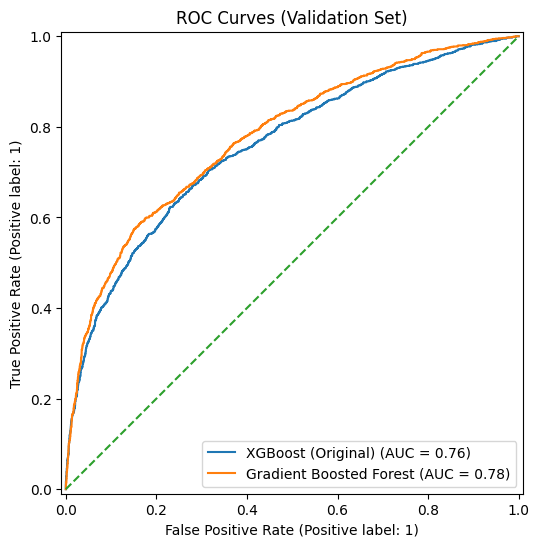

In [10]:
# Plot ROC for all models
fig, ax = plt.subplots(figsize=(8, 6))
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_test, y_proba, name=name, ax=ax)
    
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.title('ROC Curves (Validation Set)')
plt.savefig('roc_curves.pdf', dpi=300, bbox_inches='tight', format = "pdf")

In [35]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, make_scorer, f1_score
class_1_f1 = make_scorer(f1_score, average='binary', pos_label=1)
# Phase 1: XGBoost with Preprocessing & GPU Optimization (Recommended)
# ---------------------------------------------------------------
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=3.5,
        random_state=42,
        tree_method='hist',  # Optimized for CPU
        n_jobs=-1  # Use all CPU cores
    ))
])

xgb_param_grid = {
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 4],
    'classifier__subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb_pipe,
    xgb_param_grid,
    cv=5,
    scoring=make_scorer(f1_score, pos_label=1),
    n_jobs=1,  # XGBoost already uses all cores
    verbose=1
)
xgb_grid.fit(X_train, y_train)

# ---------------------------------------------------------------
# Phase 2: Random Forest with CPU Optimization
# ---------------------------------------------------------------
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1  # Use all cores
    ))
])

rf_param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [10, None],
    'classifier__min_samples_split': [5, 10]
}

rf_grid = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    scoring=make_scorer(f1_score, pos_label=1),
    n_jobs=-1,
    verbose=1
)
# rf_grid.fit(X_train, y_train)

# ---------------------------------------------------------------
# Phase 3: Gradient Boosted Classifier
# ---------------------------------------------------------------
gbf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(
        learning_rate=0.1,
        class_weight="balanced",
        random_state=42,
        categorical_features="from_dtype"
            
))
])

gbf_param_grid = {
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_iter': [200, 300],
    'classifier__max_depth': [10, None]
}

gbf_grid = GridSearchCV(
    gbf_pipe,
    gbf_param_grid,
    cv=5,
    scoring=make_scorer(f1_score, pos_label=1),
    n_jobs=-1,
    verbose=1
)
gbf_grid.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['4',
                                                                                                     '1',
                                                                                                     '3',
                                                                                                     '2'],
                                                                                                    ['-2',
                                                                                                     '-1',
                                                                                                     '0',
                                                                                                     '1',
                                                                                                     '2',
                                                                                                     '3',
                                                                                                     '4',
                                                                                                     '5',
                                                                                                     '6',
                                                                                                     '7',
                                                                                                     '8'],
                                                                                                    ['-2',
                                                                                                     '-1',
                                                                                                     '0',
                                                                                                     '1',
                                                                                                     '2',
                                                                                                     '3',
                                                                                                     '4',
                                                                                                     '5',
                                                                                                     '6',
                                                                                                     '7',
                                                                                                     '8'],
                                                                                                    ['-2',
                                                                                                     '-1',
                                                                                                     '0',
                                                                                                     '1',
                                                                                                     '2',
                                                                                                     '3',
                                                                                                     '4',
                                                                                                     '5',
                                                                                                     '6',
                                                                                                     '7',
                

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.calibration import CalibratedClassifierCV
best_xgb = xgb_grid.best_estimator_
best_rf = rf_grid.best_estimator_
best_gbf = gbf_grid.best_estimator_

# Create meta-ensemble with pipeline awareness
hybrid_model_voting = VotingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('rf', best_rf)
    ],
    voting='soft',
    n_jobs=2  # Reduced for macOS stability
)


hybrid_param_grid = {
    'weights': [[1,1], [2,1], [1,2]],
    'xgb__classifier__reg_alpha': [0, 0.1],  # Match pipeline structure
    'rf__classifier__max_depth': [15, 20]     # Adjusted for pipeline
}

hybrid_grid = GridSearchCV(
    estimator=hybrid_model,
    param_grid=hybrid_param_grid,
    cv=3,
    scoring=class_1_f1,
    refit=True,
    n_jobs=-1  # Safer for macOS threading
)

print("Fitting Hybrid model")
hybrid_grid.fit(X_train, y_train)

# Phase 4: Calibration (Modified for Pipeline Workflow)
best_hybrid = hybrid_grid.best_estimator_

# Create calibration wrapper that preserves pipeline
calibrated_hybrid = CalibratedClassifierCV(
    best_hybrid,
    cv=3,
    method='isotonic',
    n_jobs=-1
)
print("fitting calibrated hybrid")
calibrated_hybrid.fit(X_train, y_train)


# Create meta-ensemble with pipeline awareness
hybrid_model_stacking = StackingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('gbf', best_gbf)
    ],
    voting='soft',
    n_jobs=-1,
    verbose=1   # Reduced for macOS stability
)



Fitting Hybrid model
fitting calibrated hybrid


CalibratedClassifierCV(cv=3,
                       estimator=VotingClassifier(estimators=[('xgb',
                                                               Pipeline(steps=[('preprocessor',
                                                                                ColumnTransformer(transformers=[('ordinal',
                                                                                                                 OrdinalEncoder(categories=[['4',
                                                                                                                                             '1',
                                                                                                                                             '3',
                                                                                                                                             '2'],
                                                                                                                                            ['-2',
                                                                                                                                             '-1',
                                                                                                                                             '0',
                                                                                                                                             '1',
                                                                                                                                             '2',
                                                                                                                                             '3',
                                                                                                                                             '4',
                                                                                                                                             '5',
                                                                                                                                             '6',
                                                                                                                                             '7',
                                                                                                                                             '8'],
                                                                                                                                            ['-2',
                                                                                                                                             '-1',
                                                                                                                                             '0',
                                                                                                                                             '1',
                                                                                                                                             '2',
                                                                                                                                             '3',
                                                                                                                                             '4',
                                                                                                                                             '5',
                                                                                                                                             '6',
                                                                                                                                             '7',
                         

In [40]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
best_xgb = xgb_grid.best_estimator_
best_gbf = gbf_grid.best_estimator_# Create meta-ensemble with pipeline awareness
hybrid_model_stacking = StackingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('gbf', best_gbf)
    ],
    n_jobs=-1,
    verbose=1   # Reduced for macOS stability
)
hybrid_model_stacking.fit(X_train, y_train).score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


0.8163333333333334

In [42]:
def optimize_threshold(model, X_val, y_val):
    from sklearn.metrics import precision_recall_curve
    
    # Keep as DataFrame - don't convert to NumPy
    y_probs = model.predict_proba(X_val)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_probs)
    
    f1_scores = np.nan_to_num((2 * precision * recall) / (precision + recall))
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx]

# FIXED CODE FLOW
print("Optimizing threshold")
# Pass DataFrames directly - no conversion to arrays
threshold = optimize_threshold(hybrid_model_stacking, X_test, y_test)

# Generate predictions using DataFrame input
y_probs = hybrid_model_stacking.predict_proba(X_test)[:,1]
y_pred = (y_probs >= threshold).astype(int)

# Performance Analysis
print("\n" + "="*40)
print("Final Hybrid Model Performance")
print("="*40)
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))
print(f"Optimal Decision Threshold: {threshold:.3f}")
print(f"Key Metadata:")
print(f"- Best XGB params: {xgb_grid.best_params_}")
# print(f"- Best RF params: {rf_grid.best_params_}")
# print(f"- Hybrid weights: {hybrid_model_stacking.best_estimator_.weights}")

Optimizing threshold

Final Hybrid Model Performance
              precision    recall  f1-score   support

     Class 0       0.87      0.86      0.87      4673
     Class 1       0.53      0.56      0.54      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.71      6000
weighted avg       0.80      0.79      0.80      6000

Optimal Decision Threshold: 0.306
Key Metadata:
- Best XGB params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__subsample': 1.0}
